## Target Customer Identification and Marketing Strategy Simulator
Data-Driven Promotion Allocation Using Customer Segments


1️⃣ Business Problem 
Key Question:  Which customers should receive marketing promotions to maximize Return on Investment (ROI)?

Instead of treating customers individually, we:

    Treat clusters / quadrants as decision-making units
    
    Design a rule-based marketing recommendation engine
    
    Simulate ROI outcomes under different marketing strategies

In [1]:
# 2 IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 3 LOAD DATA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_csv("Mall_Customers.csv")

X = df[["Annual Income (k$)", "Spending Score (1-100)"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4


In [3]:
#4 The “Square” (Quadrant) Concept Explained
# We divide customers into Income × Spending quadrants
# We compute median thresholds to define the square.
income_median = df["Annual Income (k$)"].median()
spending_median = df["Spending Score (1-100)"].median()

income_median, spending_median


(np.float64(61.5), np.float64(50.0))

In [4]:
# 5 Assign Quadrants (Rule-Based System)
def assign_quadrant(row):
    if row["Annual Income (k$)"] >= income_median and row["Spending Score (1-100)"] >= spending_median:
        return "High Income – High Spending"
    elif row["Annual Income (k$)"] >= income_median and row["Spending Score (1-100)"] < spending_median:
        return "High Income – Low Spending"
    elif row["Annual Income (k$)"] < income_median and row["Spending Score (1-100)"] >= spending_median:
        return "Low Income – High Spending"
    else:
        return "Low Income – Low Spending"

df["Quadrant"] = df.apply(assign_quadrant, axis=1)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Quadrant
0,1,Male,19,15,39,4,Low Income – Low Spending
1,2,Male,21,15,81,2,Low Income – High Spending
2,3,Female,20,16,6,4,Low Income – Low Spending
3,4,Female,23,16,77,2,Low Income – High Spending
4,5,Female,31,17,40,4,Low Income – Low Spending


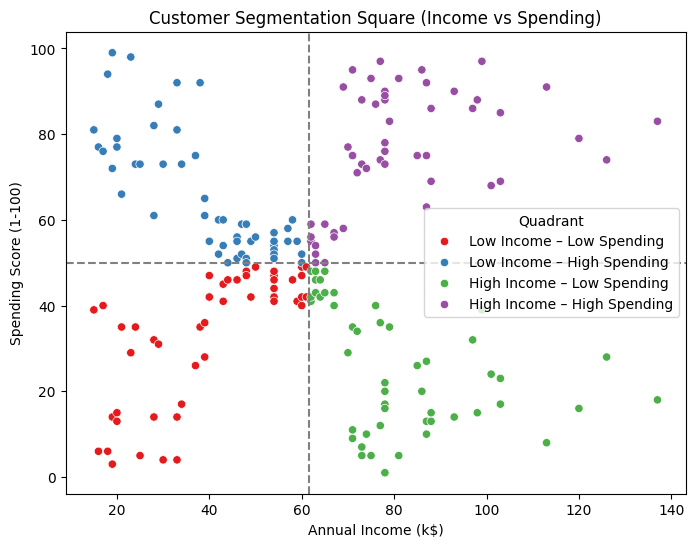

In [5]:
# 6 VISUALIZE THE SQUARE
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Quadrant",
    data=df,
    palette="Set1"
)

plt.axvline(income_median, linestyle="--", color="grey")
plt.axhline(spending_median, linestyle="--", color="grey")

plt.title("Customer Segmentation Square (Income vs Spending)")
plt.show()

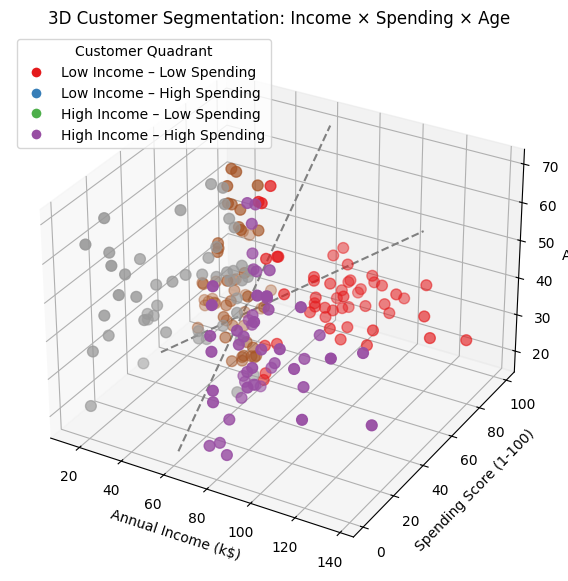

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
scatter = ax.scatter(
    df["Annual Income (k$)"],
    df["Spending Score (1-100)"],
    df["Age"],
    c=df["Quadrant"].astype("category").cat.codes,
    cmap="Set1",
    s=60
)

# Axis labels
ax.set_xlabel("Annual Income (k$)")
ax.set_ylabel("Spending Score (1-100)")
ax.set_zlabel("Age")

# Decision boundaries (Income & Spending)
ax.plot(
    [income_median, income_median],
    [df["Spending Score (1-100)"].min(), df["Spending Score (1-100)"].max()],
    [df["Age"].min(), df["Age"].max()],
    linestyle="--",
    color="grey"
)

ax.plot(
    [df["Annual Income (k$)"].min(), df["Annual Income (k$)"].max()],
    [spending_median, spending_median],
    [df["Age"].min(), df["Age"].max()],
    linestyle="--",
    color="grey"
)

# Legend (manual for clarity)
legend_labels = df["Quadrant"].unique()
handles = [
    plt.Line2D([0], [0], marker="o", color="w",
               label=label,
               markerfacecolor=plt.cm.Set1(i),
               markersize=8)
    for i, label in enumerate(legend_labels)
]

ax.legend(handles=handles, title="Customer Quadrant")

plt.title("3D Customer Segmentation: Income × Spending × Age")
plt.show()


We extended the traditional income–spending segmentation square into a 3D decision space by incorporating age, allowing us to observe how demographic factors interact with purchasing behavior. This enables more precise targeting, for example distinguishing young high spenders from older premium customers.

In [13]:
# 7 SEGMENT STATISTICS
segment_stats = df.groupby("Quadrant").agg(
    Customers=("CustomerID", "count"),
    Avg_Income=("Annual Income (k$)", "mean"),
    Avg_Spending=("Spending Score (1-100)", "mean")
)

segment_stats

,Customers,Avg_Income,Avg_Spending
Quadrant,,,
High Income – High Spending,50,81.660000,76.180000
High Income – Low Spending,50,81.460000,24.760000
Low Income – High Spending,52,39.557692,65.250000
Low Income – Low Spending,48,39.562500,33.333333


In [7]:
# 8 8️⃣ Marketing Strategy Mapping (DECISION ENGINBE)
strategy_map = {
    "High Income – High Spending": "Loyalty Rewards & VIP Programs",
    "High Income – Low Spending": "Upselling & Personalized Offers",
    "Low Income – High Spending": "Discounts & Flash Sales",
    "Low Income – Low Spending": "Cost-Control / No Promotion"
}

df["Marketing_Strategy"] = df["Quadrant"].map(strategy_map)
df[["CustomerID", "Quadrant", "Marketing_Strategy"]].head()

,CustomerID,Quadrant,Marketing_Strategy
0,1,Low Income – Low Spending,Cost-Control / No Promotion
1,2,Low Income – High Spending,Discounts & Flash Sales
2,3,Low Income – Low Spending,Cost-Control / No Promotion
3,4,Low Income – High Spending,Discounts & Flash Sales
4,5,Low Income – Low Spending,Cost-Control / No Promotion


In [8]:
# 9 ROI Assumptions (Simulation Logic) We simulate expected ROI per segment.
roi_assumptions = {
    "High Income – High Spending": 1.6,
    "High Income – Low Spending": 1.8,
    "Low Income – High Spending": 1.4,
    "Low Income – Low Spending": 0.8
}

df["Expected_ROI"] = df["Quadrant"].map(roi_assumptions)

In [9]:
# 10 ROI Simulation by Segment
roi_summary = df.groupby("Quadrant").agg(
    Customers=("CustomerID", "count"),
    Avg_ROI=("Expected_ROI", "mean"),
    Total_ROI=("Expected_ROI", "sum")
).sort_values("Total_ROI", ascending=False)

roi_summary

,Customers,Avg_ROI,Total_ROI
Quadrant,,,
High Income – Low Spending,50,1.8,90.0
High Income – High Spending,50,1.6,80.0
Low Income – High Spending,52,1.4,72.8
Low Income – Low Spending,48,0.8,38.4


In [10]:
# 11 TARGET vs NON-TARGET DECISION
df["Target_For_Promotion"] = df["Quadrant"].isin([
    "High Income – High Spending",
    "High Income – Low Spending",
    "Low Income – High Spending"
])

df["Target_For_Promotion"].value_counts()

Target_For_Promotion
True     152
False     48
Name: count, dtype: int64

Low Income – Low Spending customers are intentionally excluded.This shows cost-awareness, not just growth obsession.

In [11]:
# 12 Final Recommendation Table (Portfolio-Ready)
final_recommendation = df.groupby("Quadrant").agg(
    Customers=("CustomerID", "count"),
    Strategy=("Marketing_Strategy", "first"),
    Avg_ROI=("Expected_ROI", "mean")
)

final_recommendation

,Customers,Strategy,Avg_ROI
Quadrant,,,
High Income – High Spending,50,Loyalty Rewards & VIP Programs,1.6
High Income – Low Spending,50,Upselling & Personalized Offers,1.8
Low Income – High Spending,52,Discounts & Flash Sales,1.4
Low Income – Low Spending,48,Cost-Control / No Promotion,0.8


## Business Interpretation
Key Insights
    High Income – Low Spending offers the highest growth leverage
    
    High Income – High Spending should be retained, not discounted
    
    Low Income – High Spending responds well to promotions
    
    Low Income – Low Spending should not receive marketing spend

Final Business Recommendation
Marketing promotions should be allocated based on customer quadrant, not uniformly.
This approach maximizes ROI while minimizing unnecessary marketing costs.